# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import transforms

from transformers import Pix2StructForConditionalGeneration, Pix2StructProcessor
import inspect

import random
from PIL import Image
from tqdm import tqdm

In [2]:
test_data = pd.read_csv('/kaggle/input/amazon-ml2024-100k-csvs/test_stratified.csv')
test_data.head()

,entity_name,kaggle_image_path,entity_value
0,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/514...,20.0 gram
1,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/81k...,5.2 gram
2,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/51T...,328.0 gram
3,depth,/kaggle/input/amazon-2024-100k-imgs/images/51r...,1.26 inch
4,height,/kaggle/input/amazon-2024-100k-imgs/images/51N...,40.0 centimetre


# Inferencing trained model

In [3]:
model_1 = Pix2StructForConditionalGeneration.from_pretrained('/kaggle/input/amazon-3ep-16k/Epoch-1-model')
processor_1 = Pix2StructProcessor.from_pretrained('/kaggle/input/amazon-3ep-16k/Epoch-1-processor')

In [4]:
def random_predict(train_data, model, processor, n):
    if n>5:
        print("Too big. Setting n to 5.")
        n=5
    elif n<=0:
        print("Too small, setting n to 1.")
        n=1
    for i in range(n):
        random_number = random.randint(0, len(train_data)-1)        
        image = Image.open(train_data['kaggle_image_path'][random_number])
        plt.imshow(image)
        plt.axis("off")
        plt.show()
        
        text = f"What is the {train_data['entity_name'][random_number]} and its unit in this image?"
        inputs = processor(images=image, text=text, padding="max_length",
                           truncation=True, max_length=15, return_tensors="pt", add_special_tokens=False)

        outputs = model.generate(**inputs)
        result = processor.decode(outputs[0], skip_special_tokens=True)

        print("Random Number (Index) :", random_number)
        print("Question : ", text)
        print("Result : ", result)
        print("Original : ", train_data['entity_value'][random_number])
        print("*"*100)

Too big. Setting n to 5.


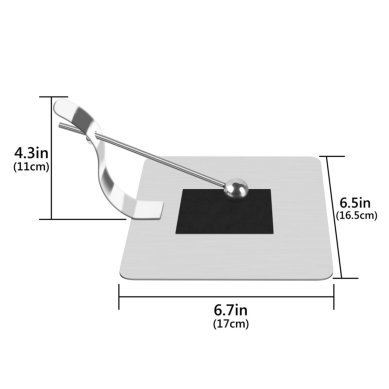

Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, If both images and text are provided, image_processor is not a VQA processor, and `add_special_tokens` is unset, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer. To test the new behavior, set `legacy=False`as a processor call argument.


Arial.TTF:   0%|          | 0.00/276k [00:00<?, ?B/s]

Random Number (Index) : 8125
Question :  What is the height and its unit in this image?
Result :  16.5 centimetre
Original :  11.0 centimetre
****************************************************************************************************


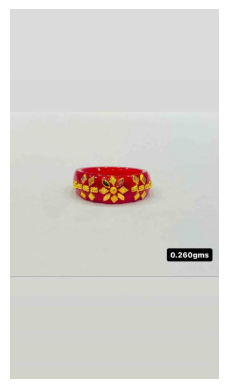

Random Number (Index) : 18104
Question :  What is the item_weight and its unit in this image?
Result :  0.28 gram
Original :  0.26 gram
****************************************************************************************************


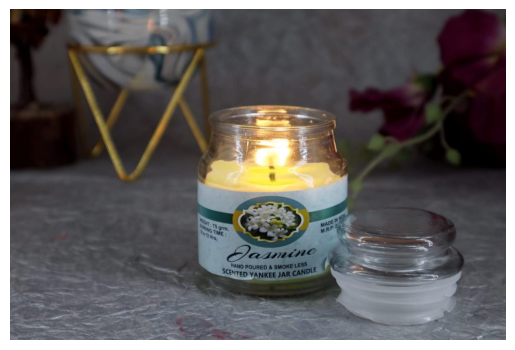

Random Number (Index) : 11791
Question :  What is the item_weight and its unit in this image?
Result :  100 gram
Original :  70.0 kilogram
****************************************************************************************************


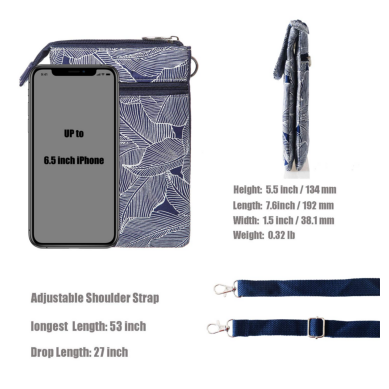

Random Number (Index) : 11317
Question :  What is the item_weight and its unit in this image?
Result :  0.32 pound
Original :  0.32 pound
****************************************************************************************************


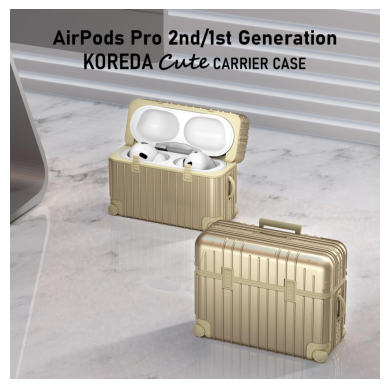

Random Number (Index) : 11563
Question :  What is the item_weight and its unit in this image?
Result :  2.0 pound
Original :  2.0 pound
****************************************************************************************************


In [5]:
random_predict(test_data, model_1, processor_1, 7)

In [6]:
test_data['prediction'] = ""
test_data.head()

,entity_name,kaggle_image_path,entity_value,prediction
0,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/514...,20.0 gram,
1,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/81k...,5.2 gram,
2,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/51T...,328.0 gram,
3,depth,/kaggle/input/amazon-2024-100k-imgs/images/51r...,1.26 inch,
4,height,/kaggle/input/amazon-2024-100k-imgs/images/51N...,40.0 centimetre,


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_1.to(device)
print("Moved to :", device)

Moved to : cuda


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

In [9]:
model_1.eval()
with torch.inference_mode():
    for idx in tqdm(test_data.index, desc="Predicting...."):
        image = Image.open(test_data['kaggle_image_path'][idx]).convert("RGB")
        image = transform(image)

        text = f"What is the {test_data['entity_name'][idx]} and its unit in this image?"
        inputs = processor_1(images=image, text=text, padding="max_length",
                           truncation=True, max_length=15, return_tensors="pt", add_special_tokens=False)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        output = model_1.generate(**inputs)
        result = processor_1.decode(output[0], skip_special_tokens=True)
        test_data.loc[idx, 'prediction'] = result

Predicting....: 100%|██████████| 20000/20000 [2:40:46<00:00,  2.07it/s]  


In [10]:
test_data.head()

,entity_name,kaggle_image_path,entity_value,prediction
0,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/514...,20.0 gram,20 gram
1,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/81k...,5.2 gram,300.0 milligram
2,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/51T...,328.0 gram,128.0 gram
3,depth,/kaggle/input/amazon-2024-100k-imgs/images/51r...,1.26 inch,6.31 millimetre
4,height,/kaggle/input/amazon-2024-100k-imgs/images/51N...,40.0 centimetre,40.0 centimetre


In [12]:
test_data.to_csv("Result.csv")